# 2024 CITS4012 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

## imports

In [1]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger_eng")

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


## Dataset Path




In [2]:
db_path = "dataset"

train_file = f"{db_path}/train.json"
test_file = f"{db_path}/test.json"
val_file = f"{db_path}/validation.json"

# 1.Dataset Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [3]:
import json
with open(train_file, "r") as fp:
    train = json.load(fp)
with open(val_file, "r") as fp:
    val = json.load(fp)
with open(test_file, "r") as fp:
    test = json.load(fp)

train['premise']['0'], train['hypothesis']['0'], train['label']['0'], len(train['premise'])



('Pluto rotates once on its axis every 6.39 Earth days;',
 'Earth rotates on its axis once times in one day.',
 'neutral',
 23088)

In [4]:
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
from nltk import pos_tag
import numpy as np


class Config:
    stem = False
    stemmer = PorterStemmer()
    lemmatize = True
    lemmatizer = WordNetLemmatizer()
    tokenize = True

    clean_text = True
    regex = r"[^a-z0-9\-\s]"

    pos = True
    pos_tagger = pos_tag

    lower = True

    stopwords = set(stopwords.words('english'))




class textProcesser():
    def __init__(self, cfg: Config) -> None:
        self.cfg = cfg

        self.lemmatizer = cfg.lemmatizer
        self.stemmer = cfg.stemmer
        self.stop_words = cfg.stopwords

        self.pos_tagger = cfg.pos_tagger


    def clean(self, sentence: str) -> list[str]:
        tokens = [sentence]
        if self.cfg.tokenize:
            tokens = nltk.word_tokenize(sentence)

        if self.cfg.lemmatize:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        if self.cfg.stem:
            tokens = [self.stemmer.stem(token) for token in tokens]

        if self.cfg.clean_text:
                
            tokens = [re.sub(self.cfg.regex, '', token.lower() if self.cfg.lower else token) for token in tokens]
            tokens = [token for token in tokens if token and token not in self.stop_words]

        if self.cfg.pos:
            tokens_pos = pos_tag(tokens)
            tokens, pos_tags = zip(*tokens_pos) if tokens_pos else ([], [])
            return list(tokens), list(pos_tags)

        return tokens, None
    
    def clean_text(self, json):
        clean = {
            'premise': {},
            'premise_pos': {},
            'hypothesis': {},
            'hypothesis_pos': {},
            'label': {}
        }

        for idx, key in enumerate(json['label'].keys()):
            p_tokens, p_pos = self.clean(json['premise'][key])
            h_tokens, h_pos = self.clean(json['hypothesis'][key])

            if len(p_tokens) == 0 or len(h_tokens) == 0:
                print(f" Warning: Empty premise or hypothesis at index {idx} (key: {key}).")

            clean['label'][idx] = 0 if 'neutral' in json['label'][key] else 1
            clean['premise'][idx] = p_tokens
            clean['premise_pos'][idx] = p_pos
            clean['hypothesis'][idx] = h_tokens
            clean['hypothesis_pos'][idx] = h_pos

        return clean

In [5]:
cfg = Config()

clean_train = textProcesser(cfg).clean_text(train)
clean_val = textProcesser(cfg).clean_text(val)
clean_test = textProcesser(cfg).clean_text(test)
clean_train['premise'][146], clean_train['hypothesis'][146], clean_train['label'][146], clean_train['premise_pos'][146], clean_train['hypothesis_pos'][146]

([],
 ['take', 'earth', 'one', 'week', 'rotate', 'axis', 'seven', 'time'],
 0,
 [],
 ['VB', 'NN', 'CD', 'NN', 'NN', 'VBD', 'CD', 'NN'])

In [6]:
import pandas as pd
train_df = pd.DataFrame({
    "label": clean_train["label"],
    "premise": clean_train["premise"],
    "hypothesis": clean_train["hypothesis"],
    "premise_pos": clean_train["premise_pos"],
    "hypothesis_pos": clean_train["hypothesis_pos"]
})

val_df = pd.DataFrame({
    "label": clean_val["label"],
    "premise": clean_val["premise"],
    "hypothesis": clean_val["hypothesis"],
    "premise_pos": clean_val["premise_pos"],
    "hypothesis_pos": clean_val["hypothesis_pos"]
})

test_df = pd.DataFrame({
    "label": clean_test["label"],
    "premise": clean_test["premise"],
    "hypothesis": clean_test["hypothesis"],
    "premise_pos": clean_test["premise_pos"],
    "hypothesis_pos": clean_test["hypothesis_pos"]
})

train_df = train_df.reset_index(drop=True)
train_df.head()

,label,premise,hypothesis,premise_pos,hypothesis_pos
0,0,"[pluto, rotates, axis, every, 639, earth, day]","[earth, rotates, axis, time, one, day]","[NN, NNS, VBP, DT, CD, NN, NN]","[NN, VBZ, JJ, NN, CD, NN]"
1,1,"[--, -glenn, per, day, earth, rotates, axis]","[earth, rotates, axis, time, one, day]","[:, NN, IN, NN, NN, VBZ, IN]","[NN, VBZ, JJ, NN, CD, NN]"
2,0,"[geyser, -, periodic, gush, hot, water, surfac...","[surface, sun, much, hotter, almost, anything,...","[SYM, :, JJ, NN, JJ, NN, NN, NN]","[NN, NN, JJ, NN, RB, NN, JJ]"
3,1,"[facts, liquid, water, droplet, changed, invis...","[evaporation, responsible, changing, liquid, w...","[NNS, JJ, NN, NN, VBD, JJ, NN, NN, NN, VBN, NN]","[NN, JJ, VBG, JJ, NN, NN, NN]"
4,1,"[comparison, earth, rotates, axis, per, day, r...","[earth, rotates, axis, time, one, day]","[NN, NN, VBZ, JJ, IN, NN, VBZ, IN, NN, IN, NN]","[NN, VBZ, JJ, NN, CD, NN]"


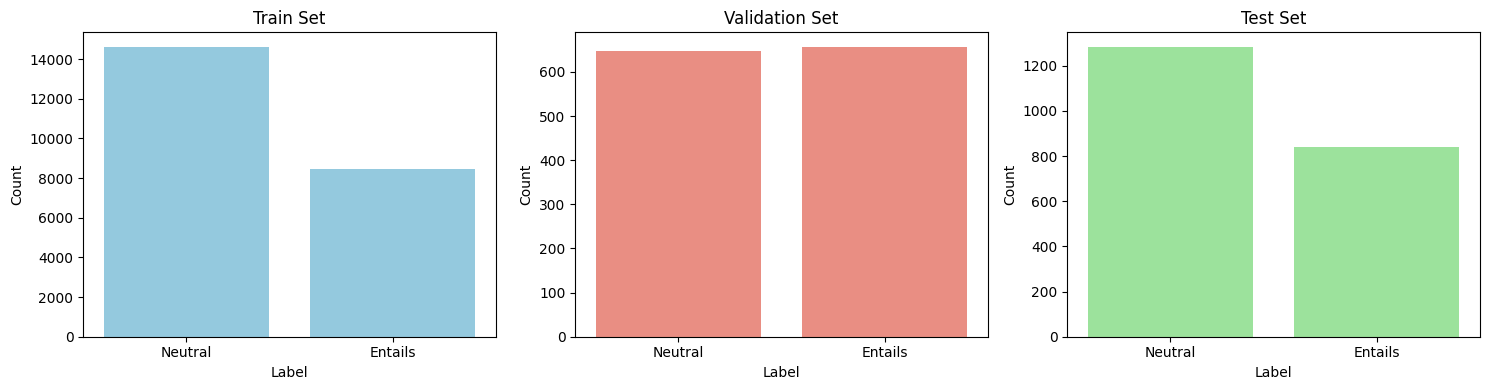

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

splits = [('Train', train_df), ('Validation', val_df), ('Test', test_df)]
colors = ['skyblue', 'salmon', 'lightgreen']  # one color per split

plt.figure(figsize=(15,4))

for i, ((name, df), color) in enumerate(zip(splits, colors), 1):
    plt.subplot(1, 3, i)
    counts = df['label'].value_counts().sort_index()
    sns.barplot(x=['Neutral', 'Entails'], y=counts.values, color=color)
    plt.title(f"{name} Set")
    plt.xlabel("Label")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [80]:
# Build pos2idx from training set only
all_pos_tags = set()
for pos_list in train_df['premise_pos']:
    all_pos_tags.update(pos_list)
for pos_list in train_df['hypothesis_pos']:
    all_pos_tags.update(pos_list)

# Add a special <UNK> token
pos2idx = {pos: i for i, pos in enumerate(sorted(all_pos_tags))}
pos2idx['<UNK>'] = len(pos2idx)
num_pos_tags = len(pos2idx)

def encode_pos(pos_list, pos2idx):
    return [pos2idx.get(pos, pos2idx['<UNK>']) for pos in pos_list]


len(pos2idx)


37

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,  DataLoader

class nliDataset(Dataset):
  def __init__(self, df, embed_model, pos_embed_model=None):
    self.df = df
    self.embed_model = embed_model
    self.pos_encode = encode_pos

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    premise = self.df["premise"].iloc[index]
    hypothesis = self.df["hypothesis"].iloc[index]
    p_embed = np.array([self.embed_model.wv[word] for word in premise if word in self.embed_model.wv])
    h_embed = np.array([self.embed_model.wv[word] for word in hypothesis if word in self.embed_model.wv])

    if len(p_embed) == 0:
        p_embed = np.zeros((1, self.embed_model.vector_size))
    if len(h_embed) == 0:
        h_embed = np.zeros((1, self.embed_model.vector_size))
    

    premise_pos = self.df["premise_pos"].iloc[index]
    hypothesis_pos = self.df["hypothesis_pos"].iloc[index]

    premise_pos = torch.tensor(self.pos_encode(premise_pos, pos2idx), dtype=torch.long)
    hypothesis_pos = torch.tensor(self.pos_encode(hypothesis_pos, pos2idx), dtype=torch.long)


    label = int(self.df["label"].iloc[index])
    p_embed = torch.tensor(p_embed, dtype=torch.float32)
    h_embed = torch.tensor(h_embed, dtype=torch.float32)
    label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
    
    sample = {
        "p_embed": p_embed,
        "h_embed": h_embed,
        "label": label,
        "premise_pos": premise_pos,
        "hypothesis_pos": hypothesis_pos
    }

    return sample


In [85]:
import torch
from torch.nn.utils.rnn import pad_sequence
def collate_fn(batch):
    p_embeds = [item["p_embed"] for item in batch]
    h_embeds = [item["h_embed"] for item in batch]
    p_pos_idx = [item["premise_pos"] for item in batch]
    h_pos_idx = [item["hypothesis_pos"] for item in batch]
    labels = [item["label"] for item in batch]

    # Get max lengths from word embeddings
    max_len_px = max([x.shape[0] for x in p_embeds])
    max_len_hx = max([x.shape[0] for x in h_embeds])

    # Pad word embeddings
    p_padded = pad_sequence(p_embeds, batch_first=True)  # shape: [B, max_len_px, emb_dim]
    h_padded = pad_sequence(h_embeds, batch_first=True)  # shape: [B, max_len_hx, emb_dim]

    # Pad POS indices **to match word embeddings**
    p_pos_padded = torch.stack([
        torch.cat([x, torch.zeros(max_len_px - x.shape[0], dtype=torch.long)]) if x.shape[0] < max_len_px else x
        for x in p_pos_idx
    ])
    h_pos_padded = torch.stack([
        torch.cat([x, torch.zeros(max_len_hx - x.shape[0], dtype=torch.long)]) if x.shape[0] < max_len_hx else x
        for x in h_pos_idx
    ])

    labels = torch.stack(labels)
    plengths = torch.tensor([x.shape[0] for x in p_embeds])
    hlengths = torch.tensor([x.shape[0] for x in h_embeds])

    return {
        "p_embed": p_padded,
        "h_embed": h_padded,
        "p_pos": p_pos_padded,
        "h_pos": h_pos_padded,
        "label": labels,
        "p_lengths": plengths,
        "h_lengths": hlengths
    }



In [11]:
from gensim.models import Word2Vec
sentences = list(clean_train['premise'].values()) + list(clean_train['hypothesis'].values())
embed_model = Word2Vec(sentences=sentences, vector_size=200, window=10, min_count=3, workers=2, sg=1)

In [86]:
train_db = nliDataset(train_df, embed_model=embed_model)
trainloader = DataLoader(train_db, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_db = nliDataset(val_df, embed_model=embed_model)
valloader = DataLoader(val_db, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_db = nliDataset(test_df, embed_model=embed_model)
testloader = DataLoader(test_db, batch_size=8, shuffle=True, collate_fn=collate_fn)

len(trainloader), len(valloader), len(testloader)

(2886, 163, 266)

# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Task

In [87]:
from collections import Counter
from torch.utils.data import WeightedRandomSampler
from tqdm import tqdm

class Task():
  def __init__(self, model, 
                train_df, 
                val_df, 
                save_path, 
                collate_fn=collate_fn, 
                optimizer=None,
                loss_fn=None,
                device="cpu", 
                batch_size=16, 
                weighted_sampling=False) -> None:

    self.train_df = train_df
    self.val_df = val_df

    self.optimizer = optimizer
    self.loss_fn = loss_fn

    self.save_path = save_path

    if weighted_sampling:
      labels = train_df['label'].values
      class_counts = Counter(labels)
      num_samples = len(labels)
      class_weights = {cls: num_samples/count for cls, count in class_counts.items()}
      sample_weights = [class_weights[label] for label in labels]
      sampler = WeightedRandomSampler(sample_weights, num_samples=num_samples, replacement=True)
    else:
      sampler = None
    
    train_db = nliDataset(train_df, embed_model=embed_model)
    val_db = nliDataset(val_df, embed_model=embed_model)

    self.train_loader = DataLoader(train_db, batch_size=batch_size, sampler=sampler, shuffle=True, collate_fn=collate_fn)
    self.val_loader = DataLoader(val_db, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    self.model = model
    self.device = device


    self.model = model.to(device)

    self.losses = {}
    self.losses["train"] = []
    self.losses["val"] = []

  def train_epoch(self):
    self.model.train()
    epoch_loss = 0
    for batch in tqdm(self.train_loader, total=len(self.train_loader), desc="Training"):
        
        p_padded = batch["p_embed"]
        h_padded = batch["h_embed"]
        labels = batch["label"]
        p_lengths = batch["p_lengths"]
        h_lengths = batch["h_lengths"]

        premise_pos = batch["p_pos"]
        hypothesis_pos = batch["h_pos"]
      

        p_padded = p_padded.to(self.device)
        h_padded = h_padded.to(self.device)
        labels = labels.to(self.device)

        outputs = self.model(p_padded, h_padded, p_lengths, h_lengths, premise_pos, hypothesis_pos)

        loss = self.loss_fn(outputs, labels)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(self.train_loader)
    return epoch_loss
  

  def validate_epoch(self):
    self.model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0

        for batch in tqdm(self.val_loader, total=len(self.val_loader), desc="Validating"):
            
          p_padded = batch["p_embed"]
          h_padded = batch["h_embed"]
          labels = batch["label"]
          p_lengths = batch["p_lengths"]
          h_lengths = batch["h_lengths"]

          premise_pos = batch["p_pos"]
          hypothesis_pos = batch["h_pos"]
        

          p_padded = p_padded.to(self.device)
          h_padded = h_padded.to(self.device)
          labels = labels.to(self.device)

          outputs = self.model(p_padded, h_padded, p_lengths, h_lengths, premise_pos, hypothesis_pos)
          loss = self.loss_fn(outputs, labels)
          val_loss += loss.item()

          _, predicted = torch.max(outputs, dim=1)

          correct += (predicted == labels.squeeze()).sum().item()
          total += labels.size(0)

        val_loss /= len(self.val_loader)
        accuracy = correct / total
    return val_loss, accuracy
     

  def fit(self, epochs, restore_best=True):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        train_loss = self.train_epoch()
        val_loss, val_acc = self.validate_epoch()

        self.losses["train"].append(train_loss)
        self.losses["val"].append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(self.model.state_dict(), self.save_path)
            print(f"Model saved to {self.save_path}")

    print("Training complete.")
    if restore_best:
      print("Restoring best model weights.")
      self.model.load_state_dict(torch.load(self.save_path))
    return self.losses




## BiLSTM

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class twin_LSTM(nn.Module):
    def __init__(self, input_size=100, hidden_size=128, output_size=1, 
                 dropout=0.5, bidirectional=True, n_layers=3,
                 pos_vocab_size=None, pos_emb_dim=16):
        super().__init__()
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Word + POS embeddings combined
        self.pos_embedding = nn.Embedding(pos_vocab_size, pos_emb_dim) if pos_vocab_size else None
        combined_input_size = input_size + (pos_emb_dim if pos_vocab_size else 0)

        self.px_lstm = nn.LSTM(combined_input_size, self.hidden_size, 
                               num_layers=n_layers, bidirectional=bidirectional, batch_first=True)
        self.hx_lstm = nn.LSTM(combined_input_size, self.hidden_size, 
                               num_layers=n_layers, bidirectional=bidirectional, batch_first=True)

        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.hidden_size * 2 * (2 if bidirectional else 1), output_size),
        )

    def forward(self, px, hx, plengths=None, hlengths=None, p_pos_idx=None, h_pos_idx=None):
        # Add POS embeddings if provided
        if self.pos_embedding is not None and p_pos_idx is not None and h_pos_idx is not None:
            print("POS embeddings added.")
            p_pos_emb = self.pos_embedding(p_pos_idx)
            h_pos_emb = self.pos_embedding(h_pos_idx)

            print(f"p_pos_emb shape: {p_pos_emb.shape}, h_pos_emb shape: {h_pos_emb.shape}")
            print(f"px shape before concat: {px.shape}, hx shape before concat: {hx.shape}")

            px = torch.cat([px, p_pos_emb], dim=2)
            hx = torch.cat([hx, h_pos_emb], dim=2)

        # Pack sequences
        packed_px = pack_padded_sequence(px, plengths.cpu(), batch_first=True, enforce_sorted=False)
        px_output, (px_hn, _) = self.px_lstm(packed_px)

        packed_hx = pack_padded_sequence(hx, hlengths.cpu(), batch_first=True, enforce_sorted=False)
        hx_output, (hx_hn, _) = self.hx_lstm(packed_hx)

        # Take last hidden state(s)
        if self.bidirectional:
            px_out = torch.cat([px_hn[-2], px_hn[-1]], dim=1)
            hx_out = torch.cat([hx_hn[-2], hx_hn[-1]], dim=1)
        else:
            px_out = px_hn[-1]
            hx_out = hx_hn[-1]

        out = self.fc(torch.cat([px_out, hx_out], dim=1))
        return out


In [94]:

pos_vocab_size = len(pos2idx) 
pos_emb_dim = 32              

model = twin_LSTM(
    input_size=embed_model.vector_size,
    hidden_size=128,
    output_size=1,
    dropout=0.5,
    bidirectional=True,
    n_layers=2,
    pos_vocab_size=pos_vocab_size,
    pos_emb_dim=pos_emb_dim
)

task = Task(
    model=model,
    train_df=train_df,
    val_df=val_df,
    save_path="best_model.pth",
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    loss_fn=nn.BCEWithLogitsLoss(),
    device="cuda" if torch.cuda.is_available() else "cpu",
    batch_size=8,
    weighted_sampling=False
)



In [95]:
task.validate_epoch()

Validating:   0%|          | 0/163 [00:00<?, ?it/s]

POS embeddings added.
p_pos_emb shape: torch.Size([8, 10, 32]), h_pos_emb shape: torch.Size([8, 8, 32])
px shape before concat: torch.Size([8, 10, 200]), hx shape before concat: torch.Size([8, 8, 200])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 200 but got size 32 for tensor number 1 in the list.

In [ ]:
task.fit(epochs=3)

Training:  10%|█         | 298/2886 [01:51<16:09,  2.67it/s]  


KeyboardInterrupt: 

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*